# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  

In [1]:
# Standard libraries
# import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torchvision.models as models


# PyTorch core
import torch
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
# from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, ForwardBackwardProperLoss, scoring_matrix
from utils.losses1 import PiCOLoss, IRLoss, UpperBoundWeakProperLoss
# from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
dataset_name = 'Cifar10'
#dataset_name = 'mnist'
Data = Data_handling(
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42,
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y

print(f"Number of classes: {Data.num_classes}")
print(f"Array of targets: \n {Data.test_dataset.targets}")
""" df = pd.DataFrame(
    Data.train_dataset.data.numpy(),
    # columns=[f'feature_{i}' 
    columns=[f'x_{i}' 
             for i in range(Data.train_dataset.data.shape[1])])

# Add target column
df['target'] = [i for i in Data.train_dataset.targets.numpy()]

# Print 3 rows
print(df.head(3)) """


import pandas as pd
import torch

X = Data.train_dataset.data          # (50000, 3, 32, 32)
y = torch.as_tensor(Data.train_dataset.targets)

if y.ndim > 1:
    y = y.argmax(dim=1)


# 只取前 3 个样本，flatten 成 (3, 3072)
X3 = X[:3].reshape(3, -1).cpu().numpy()
y3 = y[:3].cpu().numpy()

df = pd.DataFrame(X3, columns=[f'x_{i}' for i in range(X3.shape[1])])
df['target'] = y3

print(df.head(3))


Number of classes: 10
Array of targets: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0 -0.537255 -0.662745 -0.607843 -0.466667 -0.231373 -0.066667  0.090196   
1  0.207843 -0.011765 -0.176471 -0.200000 -0.019608  0.215686  0.349020   
2  1.000000  0.984314  0.984314  0.984314  0.984314  0.984314  0.984314   

        x_7       x_8       x_9  ...    x_3063    x_3064    x_3065    x_3066  \
0  0.137255  0.168628  0.168628  ... -0.545098 -0.490196 -0.537255 -0.639216   
1  0.411765  0.113726 -0.129412  ... -0.670588 -0.474510 -0.207843 -0.043137   
2  0.984314  0.984314  0.984314  ... -0.349020 -0.372549 -0.458824 -0.482353   

     x_3067    x_3068    x_3069    x_3070    x_3071  target  
0 -0.552941 -0.18431

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [4]:
# Generate transition matrix M
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)

weakener.generate_M(model_class='pll', corr_p=0.2) # For partial label learning (PLL)
#weakener.generate_M(model_class='unif_noise', corr_p=0.5) # For noisy labels

print(f"Generated M matrix:\n"
      f"{np.array2string(weakener.M, precision=4, suppress_small=True)}")

# Generate weak labels z
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)
z = weakener.generate_weak(
    true_onehot, compute_w=True, compute_Y=True, compute_Y_opt=False,
    compute_Y_conv=False, compute_Y_opt_conv=False)
#想跑哪种就把对应开关打开，就是改成True，其他的改成False

print(f"Generated weak labels z:\n{z}")

# Compute virtual labels
print("Computing virtual labels...")
# Since z[i] is an integer, row i must contain the z[i]-th row of weakener.Z
virtual_labels = weakener.Z[z]

# Add weak and virtual labels to the dataset
Data.include_weak(z)
Data.include_virtual(virtual_labels, initial_weight=1/Data.num_classes)

# Get dataloaders with weak labels and indices
train_loader, test_loader = Data.get_dataloader(
    weak_labels='all', get_index=True)

Generated M matrix:
[[0.     0.     0.     ... 0.     0.     0.1342]
 [0.     0.     0.     ... 0.     0.1342 0.    ]
 [0.     0.     0.     ... 0.     0.0336 0.0336]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]
Generated weak labels z:
tensor([136, 274, 162,  ...,   8, 767, 320], dtype=torch.int32)
Computing virtual labels...


In [5]:
batch = next(iter(train_loader))
xb, wb, vb, cb, yb, ib = batch
print(f"Inputs batch: shape {xb.shape}")
print(f"Weak (partial) labels: shape {wb.shape}, first row: {wb[0]}")
print(f"Virtual labels: shape {vb.shape}, first row: {vb[0]}")
print(f"Weights: shape {cb.shape}, first row: {cb[0]}")
print(f"True one-hot labels shape: {yb.shape}, first row: {yb[0]}")
print(f"Indices batch: shape {ib.shape}, first row: {ib[0]}")

Inputs batch: shape torch.Size([64, 3, 32, 32])
Weak (partial) labels: shape torch.Size([64]), first row: 136
Virtual labels: shape torch.Size([64, 10]), first row: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1])
Weights: shape torch.Size([64, 10]), first row: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
True one-hot labels shape: torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Indices batch: shape torch.Size([64]), first row: 0


In [6]:
# weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'x_{i}' for i in range(Data.train_dataset.data.shape[1])])
# df['target'] = [i for i in weakener.w.numpy()]
import pandas as pd
import torch

X = Data.train_dataset.data                    # (N,3,32,32)
w = torch.as_tensor(weakener.w)                # weak label / or soft label

n_show = 1000                                   # 不要全量转，太大
X_flat = X[:n_show].reshape(n_show, -1).cpu().numpy()  # (n_show, 3072)
w_show = w[:n_show].cpu().numpy()

# 如果 w 是 one-hot / soft label (n_show, K)，你想要 index 就 argmax
if w_show.ndim > 1:
    w_show = w_show.argmax(axis=1)

weak_df = pd.DataFrame(X_flat, columns=[f'x_{i}' for i in range(X_flat.shape[1])])
weak_df['target'] = w_show

print(weak_df.head(3))

        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0 -0.537255 -0.662745 -0.607843 -0.466667 -0.231373 -0.066667  0.090196   
1  0.207843 -0.011765 -0.176471 -0.200000 -0.019608  0.215686  0.349020   
2  1.000000  0.984314  0.984314  0.984314  0.984314  0.984314  0.984314   

        x_7       x_8       x_9  ...    x_3063    x_3064    x_3065    x_3066  \
0  0.137255  0.168628  0.168628  ... -0.545098 -0.490196 -0.537255 -0.639216   
1  0.411765  0.113726 -0.129412  ... -0.670588 -0.474510 -0.207843 -0.043137   
2  0.984314  0.984314  0.984314  ... -0.349020 -0.372549 -0.458824 -0.482353   

     x_3067    x_3068    x_3069    x_3070    x_3071  target  
0 -0.552941 -0.184314  0.098039 -0.341176 -0.435294       2  
1  0.043137  0.066667  0.090196  0.113726  0.129412       1  
2 -0.435294 -0.380392 -0.349020 -0.349020 -0.341176       2  

[3 rows x 3073 columns]




1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

In [7]:
# ##########################
# Define model and optimizer
# def get_model(Data, opt_alg='adam', lr=1e-6, momentum=0.9):
#     """ Define model and optimizer
#     Parameters
#         Data: dataset object with num_classes and num_features attributes
#     Returns
#         model: the neural network model
#         optimizer: the optimizer
#     """

#     model = MLP(
#         input_size=Data.num_features,
#         hidden_sizes=[],
#         output_size=Data.num_classes,
#         dropout_p=0,
#         bn=False,
#         activation='relu')

#     if opt_alg == 'adam':
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#     elif opt_alg == 'sgd':
#         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#     else:
#         raise ValueError(f"Unsupported optimizer: {opt_alg}") 

#     return model, optimizer


def get_model(Data, opt_alg='adam', lr=1e-3, momentum=0.9):

    class ResNet18Wrapper(nn.Module):
        def __init__(self, num_classes: int):
            super().__init__()
            net = models.resnet18(weights=None)  # 不用 ImageNet 权重
            # CIFAR-10 tweak: 32x32 小图
            net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            net.maxpool = nn.Identity()
            net.fc = nn.Linear(net.fc.in_features, num_classes)  # 改输出维度 :contentReference[oaicite:2]{index=2}
            self.net = net

        def forward(self, x):
            # 兼容 (B,3072) / (B,32,32,3) / (B,3,32,32)
            if x.dim() == 2:
                x = x.view(x.size(0), 3, 32, 32)
            elif x.dim() == 4 and x.shape[-1] == 3 and x.shape[1] != 3:
                x = x.permute(0, 3, 1, 2).contiguous()
            return self.net(x)

    model = ResNet18Wrapper(Data.num_classes)

    if opt_alg == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_alg == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_alg}")

    return model, optimizer




# ########################
# Visualization of results
def plot_results(results_df):
    """ Plot training results
    Parameters
        results_df: DataFrame with training results
    """

    # Set up a wide figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss curves
    ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
    ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Now we define a method with the steps of each simulation to test a learning algorithm

In [8]:
def run_simulation(Data, loss, num_epochs=10, optimizer_name='adam', 
                   loss_code=None, pseudolabel_model=None, lr=1e-6, corr_p=0.2,
                   phi=0.8):
    """Run a training simulation with the specified parameters.

    Parameters
    ----------
    Data : dataset object
        The dataset object containing training and test data.
    loss : loss function object
        The loss function to use for training.
    num_epochs : int, optional
        The number of training epochs (default is 10).
    optimizer_name : str, optional
        The name of the optimizer to use (default is 'adam').
    loss_code : str, optional
        A code representing the loss function (for metadata) (default is None).
    pseudolabel_model : str, optional
        A string indicating the pseudolabel model used (for metadata)
        (default is None).
    lr : float, optional
        The learning rate for the optimizer (default is 1e-6).
    corr_p : float, optional
        The corruption probability used in the weak label generation 
        (for metadata) (default is 0.2).
    phi : float, optional
        The phi parameter for the training loop (default is 0.8).
    """

    # 1. Get model and optimizer
    model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

    # 2. Run the training + evaluation loop
    model, results_df = train_and_evaluate(
        model, train_loader, test_loader, optimizer, loss, num_epochs,
        phi=phi, pseudolabel_model=pseudolabel_model)

    # 3. Save simultation attributes in a metadata dictionary
    metadata = {'pseudo_label_model': pseudolabel_model, 'loss_name': loss_code, 
                'corr_p': corr_p, 'optimizer': type(optimizer).__name__,
                'initial_lr': optimizer.param_groups[0]['lr'], 'phi': phi}
    print(pd.DataFrame([metadata]).T)

    # 4. View the epoch‐by‐epoch results
    plot_results(results_df)

    return model, optimizer, metadata, results_df

In [9]:
# #####################################
# Common parameters for all simulations

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 20
optimizer_name = 'adam'
lr = 1e-3

Using device: cuda


## Running experiments  

Epoch 10/20: Train Loss: 0.8486, Train Acc: 0.5142, Test Acc: 0.5218, Train Detached Loss: 1.7952, Test Detached Loss: 1.8482, Learning Rate: 0.001000, Epoch Time: 29.36 seconds
Epoch 20/20: Train Loss: 0.2381, Train Acc: 0.8113, Test Acc: 0.6600, Train Detached Loss: 1.1131, Test Detached Loss: 1.6223, Learning Rate: 0.001000, Epoch Time: 29.48 seconds
                                0
pseudo_label_model           PiCO
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


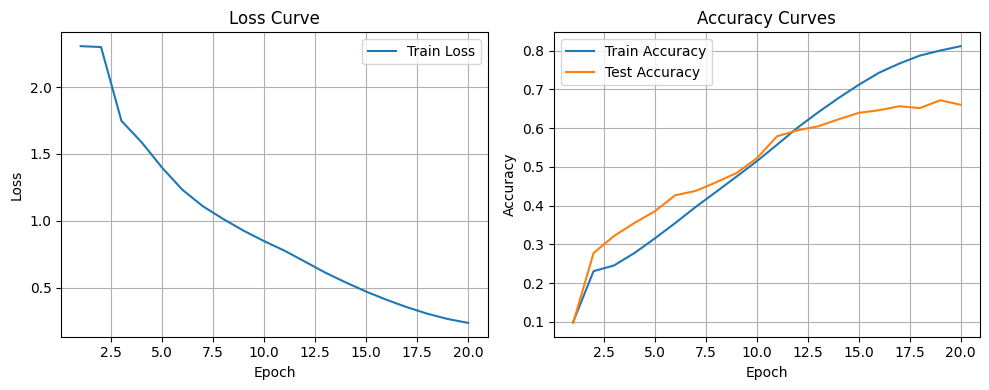

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,PiCO,2.305240,0.09966,0.0973,2.302819,2.302868,0.001,29.933253
1,2,PiCO,2.298764,0.23076,0.2773,2.111019,2.109897,0.001,29.467155
2,3,PiCO,1.747206,0.24540,0.3214,1.856282,1.840637,0.001,29.459616
3,4,PiCO,1.585743,0.27736,0.3550,1.827666,1.816922,0.001,29.421897
4,5,PiCO,1.396292,0.31504,0.3852,1.787101,1.779312,0.001,29.410143
5,6,PiCO,1.231022,0.35468,0.4265,1.753249,1.750556,0.001,29.439862
6,7,PiCO,1.108659,0.39612,0.4377,1.798170,1.808302,0.001,29.463361
7,8,PiCO,1.013544,0.43502,0.4598,1.781915,1.804347,0.001,29.500693
8,9,PiCO,0.925911,0.47434,0.4836,1.773721,1.810830,0.001,29.400452
9,10,PiCO,0.848618,0.51424,0.5218,1.795152,1.848242,0.001,29.364565


In [10]:
# #################
# Testing PiCO Loss

loss_code = "cross_entropy"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: -2.8165, Train Acc: 0.5561, Test Acc: 0.4479, Train Detached Loss: 2.9902, Test Detached Loss: 3.6747, Learning Rate: 0.001000, Epoch Time: 30.54 seconds
Epoch 20/20: Train Loss: -9.6131, Train Acc: 0.4949, Test Acc: 0.4665, Train Detached Loss: 4.6293, Test Detached Loss: 7.8623, Learning Rate: 0.001000, Epoch Time: 30.50 seconds
                                0
pseudo_label_model            BWD
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


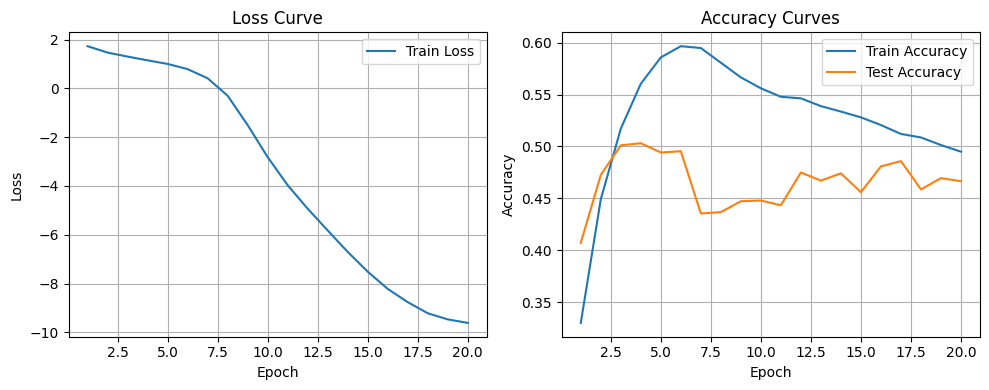

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,BWD,1.729939,0.32994,0.4071,1.687899,1.700463,0.001,30.403813
1,2,BWD,1.467190,0.44916,0.4726,1.501980,1.518480,0.001,30.462674
2,3,BWD,1.303146,0.51714,0.5011,1.478548,1.498698,0.001,30.208598
3,4,BWD,1.149527,0.56046,0.5031,1.453690,1.484358,0.001,30.413874
4,5,BWD,1.002508,0.58586,0.4942,1.553836,1.605793,0.001,30.493198
5,6,BWD,0.789559,0.59668,0.4954,1.744597,1.844717,0.001,30.581997
6,7,BWD,0.414906,0.59488,0.4354,2.608383,2.874247,0.001,29.831706
7,8,BWD,-0.300246,0.58072,0.4367,2.892756,3.429603,0.001,30.353398
8,9,BWD,-1.501721,0.56658,0.4472,3.084146,3.690606,0.001,30.589688
9,10,BWD,-2.816509,0.55606,0.4479,2.990180,3.674713,0.001,30.542454


In [11]:
# #################
# Backward Proper Loss

loss_code = "cross_entropy"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=0.8)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: 0.1120, Train Acc: 0.9084, Test Acc: 0.7819, Train Detached Loss: 0.4956, Test Detached Loss: 1.0971, Learning Rate: 0.001000, Epoch Time: 35.57 seconds
Epoch 20/20: Train Loss: 0.0509, Train Acc: 0.9319, Test Acc: 0.8079, Train Detached Loss: 0.4698, Test Detached Loss: 1.1142, Learning Rate: 0.001000, Epoch Time: 36.06 seconds
                                0
pseudo_label_model             IR
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


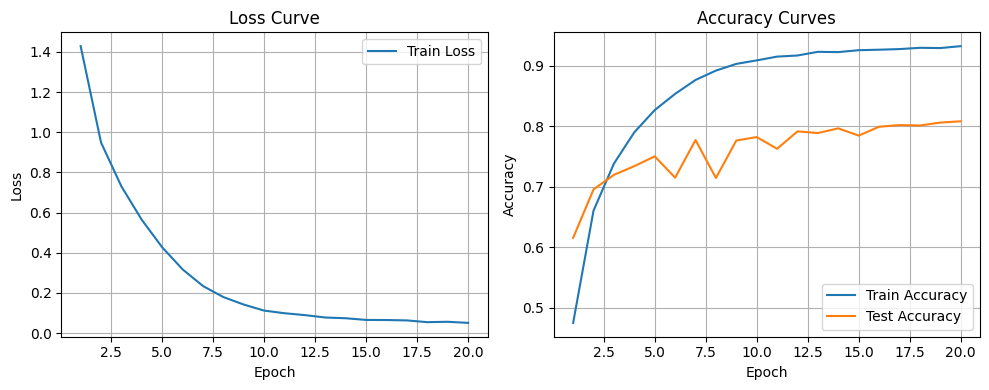

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,IR,1.428734,0.47526,0.6156,1.066587,1.087166,0.001,31.089122
1,2,IR,0.948721,0.66062,0.6956,0.824502,0.875018,0.001,35.855226
2,3,IR,0.730281,0.73816,0.7196,0.731655,0.839167,0.001,36.020043
3,4,IR,0.563641,0.78982,0.7339,0.657711,0.839827,0.001,35.756314
4,5,IR,0.427026,0.82648,0.7501,0.569307,0.838749,0.001,36.090243
5,6,IR,0.317154,0.85320,0.7149,0.816691,1.203386,0.001,35.927202
6,7,IR,0.234265,0.87614,0.7770,0.481970,0.930858,0.001,35.831440
7,8,IR,0.179322,0.89160,0.7144,0.898568,1.530823,0.001,35.754752
8,9,IR,0.142005,0.90268,0.7762,0.510256,1.083403,0.001,35.389007
9,10,IR,0.111969,0.90844,0.7819,0.495602,1.097115,0.001,35.567606


In [12]:
# #################
# Testing IR Loss

loss_code = "cross_entropy"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: 4.5667, Train Acc: 0.9093, Test Acc: 0.7884, Train Detached Loss: 0.4873, Test Detached Loss: 1.0902, Learning Rate: 0.001000, Epoch Time: 35.89 seconds
Epoch 20/20: Train Loss: 4.5214, Train Acc: 0.9304, Test Acc: 0.8106, Train Detached Loss: 0.4542, Test Detached Loss: 1.1019, Learning Rate: 0.001000, Epoch Time: 35.78 seconds
                                0
pseudo_label_model             MC
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


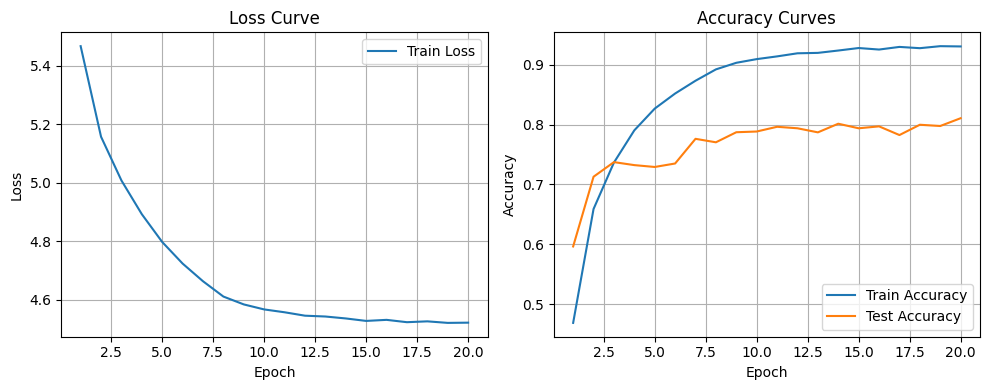

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,5.467590,0.46888,0.5965,1.110103,1.126866,0.001,36.239375
1,2,MC,5.157657,0.65900,0.7129,0.773820,0.829762,0.001,35.812452
2,3,MC,5.007980,0.73658,0.7373,0.675161,0.785917,0.001,36.014947
3,4,MC,4.892565,0.79040,0.7323,0.679182,0.859353,0.001,35.678958
4,5,MC,4.797391,0.82664,0.7292,0.698565,0.988815,0.001,35.799903
5,6,MC,4.723599,0.85184,0.7350,0.662285,1.035258,0.001,36.123810
6,7,MC,4.663104,0.87320,0.7762,0.511537,0.935972,0.001,35.880926
7,8,MC,4.610739,0.89214,0.7704,0.536033,1.093055,0.001,35.825521
8,9,MC,4.583836,0.90314,0.7872,0.489945,1.059390,0.001,35.922305
9,10,MC,4.566691,0.90928,0.7884,0.487282,1.090179,0.001,35.886355


In [13]:
# #################
# Marginal Chain

loss_code = "cross_entropy"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: 4.5632, Train Acc: 0.9109, Test Acc: 0.7830, Train Detached Loss: 0.4836, Test Detached Loss: 1.0792, Learning Rate: 0.001000, Epoch Time: 36.02 seconds
Epoch 20/20: Train Loss: 4.5211, Train Acc: 0.9304, Test Acc: 0.8023, Train Detached Loss: 0.4947, Test Detached Loss: 1.1731, Learning Rate: 0.001000, Epoch Time: 35.82 seconds
                                0
pseudo_label_model            FWD
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


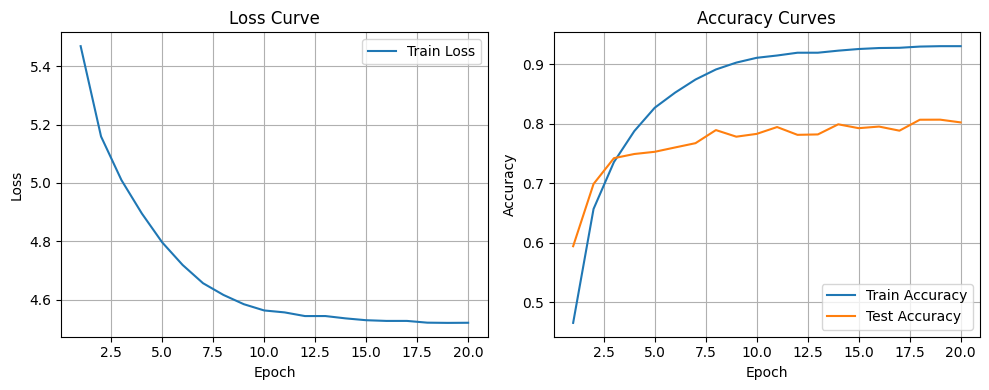

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,FWD,5.468316,0.46532,0.5942,1.131918,1.150915,0.001,36.048462
1,2,FWD,5.159075,0.65680,0.6988,0.800834,0.851692,0.001,36.073763
2,3,FWD,5.009722,0.73566,0.7422,0.657014,0.758446,0.001,36.039464
3,4,FWD,4.895405,0.78774,0.7492,0.613077,0.773592,0.001,35.989762
4,5,FWD,4.796227,0.82694,0.7529,0.593264,0.854855,0.001,35.794488
5,6,FWD,4.719024,0.85238,0.7602,0.561545,0.918442,0.001,35.977907
6,7,FWD,4.656580,0.87438,0.7674,0.502149,0.951233,0.001,36.108637
7,8,FWD,4.616437,0.89128,0.7894,0.423536,0.896784,0.001,35.771577
8,9,FWD,4.584657,0.90282,0.7783,0.479116,1.032332,0.001,35.933468
9,10,FWD,4.563206,0.91088,0.7830,0.483582,1.079200,0.001,36.024867


In [14]:
# #################
# Forward Proper Loss

loss_code = "cross_entropy"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: 0.1180, Train Acc: 0.9091, Test Acc: 0.7907, Train Detached Loss: 0.4274, Test Detached Loss: 0.9839, Learning Rate: 0.001000, Epoch Time: 36.02 seconds
Epoch 20/20: Train Loss: 0.0504, Train Acc: 0.9299, Test Acc: 0.7977, Train Detached Loss: 0.4965, Test Detached Loss: 1.2510, Learning Rate: 0.001000, Epoch Time: 36.15 seconds
                                0
pseudo_label_model             MM
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr                  0.001
phi                           0.8


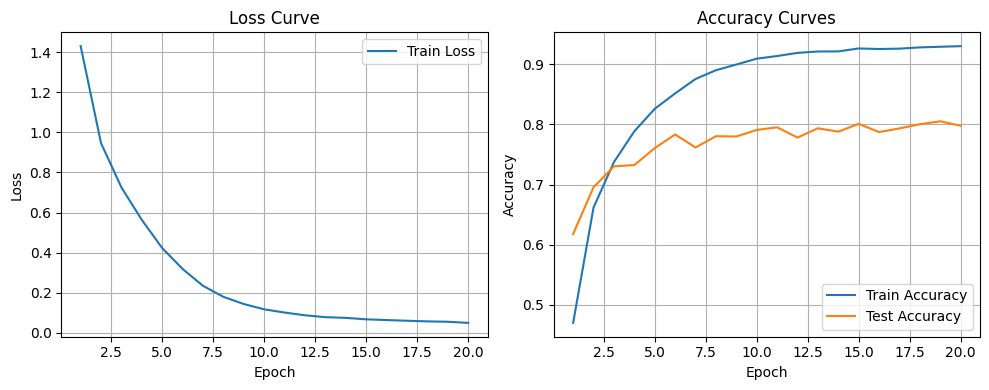

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MM,1.429196,0.47008,0.6179,1.046762,1.070439,0.001,35.556572
1,2,MM,0.945592,0.66182,0.6955,0.814962,0.880228,0.001,35.775041
2,3,MM,0.725192,0.73736,0.7302,0.701926,0.814153,0.001,35.799537
3,4,MM,0.563384,0.78840,0.7324,0.666754,0.851213,0.001,35.820156
4,5,MM,0.423117,0.82586,0.7605,0.546160,0.817472,0.001,35.689380
5,6,MM,0.319095,0.85138,0.7832,0.450034,0.782529,0.001,35.590148
6,7,MM,0.234926,0.87536,0.7615,0.559495,1.042793,0.001,35.669634
7,8,MM,0.180281,0.88994,0.7803,0.506466,1.032270,0.001,35.632818
8,9,MM,0.144391,0.89942,0.7798,0.479762,1.031168,0.001,35.747179
9,10,MM,0.117967,0.90914,0.7907,0.427408,0.983874,0.001,36.019917


In [15]:
# ############
# Majorization-Minimization (Uppder bound)

loss_code = "cross_entropy"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.0711, Train Acc: 0.1000, Test Acc: 0.1000, Train Detached Loss: 37.2586, Test Detached Loss: 37.1632, Learning Rate: 0.001000, Epoch Time: 37.17 seconds
Epoch 20/20: Train Loss: -0.0711, Train Acc: 0.1000, Test Acc: 0.1000, Train Detached Loss: 36.9798, Test Detached Loss: 36.8882, Learning Rate: 0.001000, Epoch Time: 37.09 seconds
                        0
pseudo_label_model    BWD
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


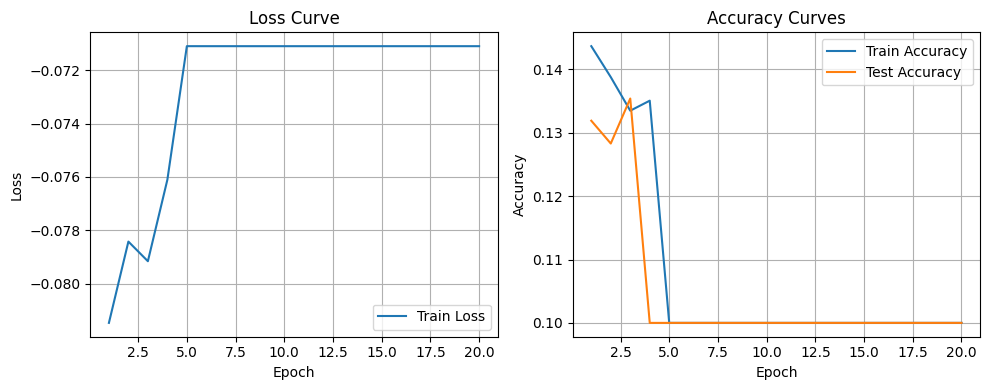

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,BWD,-0.081474,0.14366,0.1319,21.340228,21.423342,0.001,36.970577
1,2,BWD,-0.078426,0.13878,0.1283,26.358721,26.569370,0.001,37.448525
2,3,BWD,-0.079162,0.13348,0.1354,31.043432,31.087814,0.001,37.273308
3,4,BWD,-0.076107,0.13506,0.1000,37.137568,37.033448,0.001,37.083486
4,5,BWD,-0.071099,0.10000,0.1000,37.143928,37.043145,0.001,37.088768
5,6,BWD,-0.071099,0.10000,0.1000,37.172411,37.072913,0.001,37.504405
6,7,BWD,-0.071099,0.10000,0.1000,37.197105,37.098728,0.001,37.409643
7,8,BWD,-0.071099,0.10000,0.1000,37.219905,37.122594,0.001,37.333171
8,9,BWD,-0.071099,0.10000,0.1000,37.240140,37.143821,0.001,37.145523
9,10,BWD,-0.071099,0.10000,0.1000,37.258584,37.163166,0.001,37.167883


In [16]:
# #################
# Backward Proper Loss

loss_code = "ps_2"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.1432, Train Acc: 0.1000, Test Acc: 0.1000, Train Detached Loss: 22.3590, Test Detached Loss: 22.5529, Learning Rate: 0.001000, Epoch Time: 35.91 seconds
Epoch 20/20: Train Loss: -0.1436, Train Acc: 0.1000, Test Acc: 0.1000, Train Detached Loss: 24.7846, Test Detached Loss: 24.9731, Learning Rate: 0.001000, Epoch Time: 36.51 seconds
                        0
pseudo_label_model     IR
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


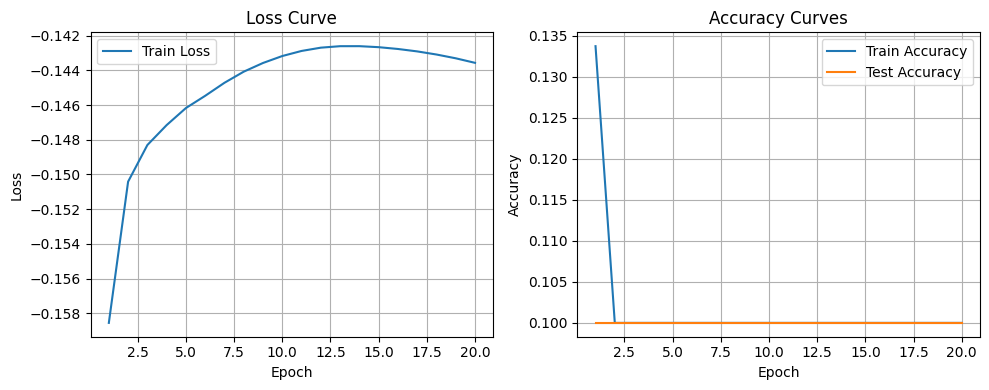

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,IR,-0.158550,0.13372,0.1,18.563448,18.840156,0.001,36.262261
1,2,IR,-0.150413,0.10000,0.1,19.744126,19.984123,0.001,36.648885
2,3,IR,-0.148302,0.10000,0.1,20.285283,20.513433,0.001,36.826855
3,4,IR,-0.147154,0.10000,0.1,20.686127,20.906770,0.001,36.486428
4,5,IR,-0.146172,0.10000,0.1,21.023883,21.238592,0.001,36.383909
5,6,IR,-0.145467,0.10000,0.1,21.326721,21.536288,0.001,36.030284
6,7,IR,-0.144717,0.10000,0.1,21.605685,21.810654,0.001,36.040160
7,8,IR,-0.144077,0.10000,0.1,21.868349,22.069139,0.001,35.856268
8,9,IR,-0.143576,0.10000,0.1,22.117316,22.314525,0.001,36.218196
9,10,IR,-0.143176,0.10000,0.1,22.358993,22.552913,0.001,35.910322


In [17]:
# #################
# Testing IR Loss

loss_code = "ps_2"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: -0.2230, Train Acc: 0.1586, Test Acc: 0.1628, Train Detached Loss: 68.0471, Test Detached Loss: 68.2021, Learning Rate: 0.001000, Epoch Time: 37.05 seconds
Epoch 20/20: Train Loss: -0.2265, Train Acc: 0.1573, Test Acc: 0.1530, Train Detached Loss: 89.3726, Test Detached Loss: 89.0570, Learning Rate: 0.001000, Epoch Time: 36.61 seconds
                        0
pseudo_label_model   PiCO
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


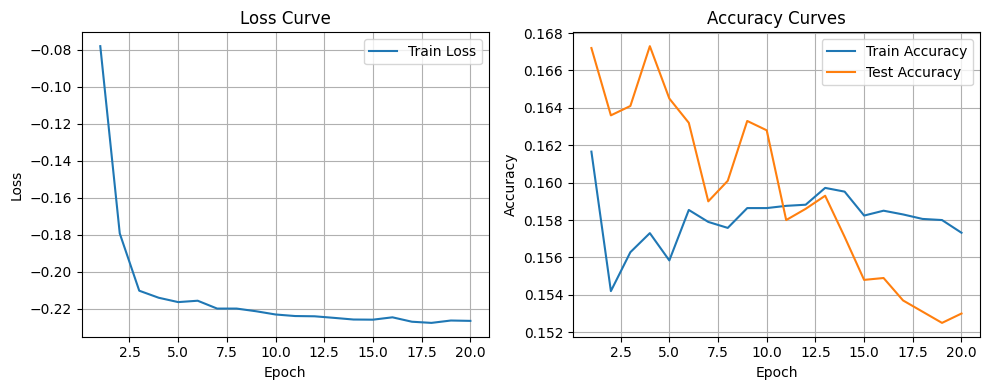

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,PiCO,-0.078142,0.16166,0.1672,28.714215,28.718612,0.001,36.746885
1,2,PiCO,-0.179266,0.15420,0.1636,30.877355,30.862188,0.001,36.764564
2,3,PiCO,-0.210183,0.15628,0.1641,38.793378,38.845808,0.001,36.731960
3,4,PiCO,-0.213987,0.15730,0.1673,43.957175,44.020326,0.001,36.974209
4,5,PiCO,-0.216332,0.15584,0.1645,51.550857,51.794647,0.001,36.605492
5,6,PiCO,-0.215589,0.15854,0.1632,49.747233,49.855711,0.001,36.770224
6,7,PiCO,-0.219833,0.15790,0.1590,52.906424,52.809359,0.001,36.766581
7,8,PiCO,-0.219827,0.15758,0.1601,62.900414,63.065513,0.001,36.799627
8,9,PiCO,-0.221274,0.15864,0.1633,64.549441,64.743832,0.001,36.676387
9,10,PiCO,-0.223023,0.15864,0.1628,68.047125,68.202148,0.001,37.049033


In [18]:
# #################
# Testing PiCO Loss

loss_code = "ps_2"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: -0.1625, Train Acc: 0.1550, Test Acc: 0.1591, Train Detached Loss: 53.0101, Test Detached Loss: 53.2049, Learning Rate: 0.001000, Epoch Time: 35.97 seconds
Epoch 20/20: Train Loss: -0.1653, Train Acc: 0.1601, Test Acc: 0.1586, Train Detached Loss: 83.4597, Test Detached Loss: 83.5514, Learning Rate: 0.001000, Epoch Time: 36.26 seconds
                        0
pseudo_label_model     MC
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


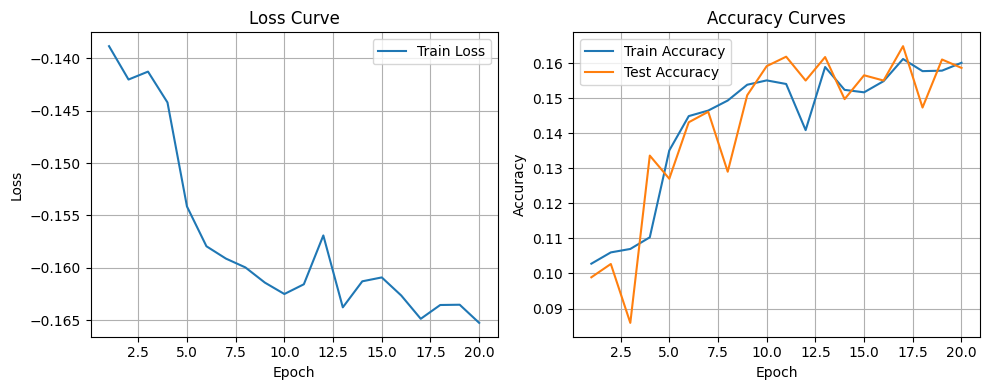

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,-0.138838,0.10278,0.0989,18.966983,19.123711,0.001,36.139850
1,2,MC,-0.142024,0.10600,0.1027,21.820994,21.958534,0.001,36.002805
2,3,MC,-0.141267,0.10698,0.0859,36.541493,36.696479,0.001,36.120491
3,4,MC,-0.144213,0.11030,0.1336,39.331694,39.433228,0.001,36.204370
4,5,MC,-0.154142,0.13506,0.1270,46.480393,46.684032,0.001,36.376153
5,6,MC,-0.157942,0.14486,0.1431,48.674501,48.881828,0.001,36.027232
6,7,MC,-0.159119,0.14644,0.1461,51.540120,51.032632,0.001,36.183690
7,8,MC,-0.159961,0.14930,0.1290,49.658091,50.115358,0.001,35.929732
8,9,MC,-0.161412,0.15380,0.1508,54.536241,54.340534,0.001,36.158284
9,10,MC,-0.162499,0.15504,0.1591,53.010094,53.204909,0.001,35.969471


In [19]:
# #################
# Marginal Chain

loss_code = "ps_2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.0014, Train Acc: 0.1634, Test Acc: 0.1676, Train Detached Loss: 44.7500, Test Detached Loss: 44.5118, Learning Rate: 0.001000, Epoch Time: 36.31 seconds
Epoch 20/20: Train Loss: -0.0015, Train Acc: 0.1696, Test Acc: 0.1752, Train Detached Loss: 73.4521, Test Detached Loss: 73.1382, Learning Rate: 0.001000, Epoch Time: 36.22 seconds
                        0
pseudo_label_model    FWD
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


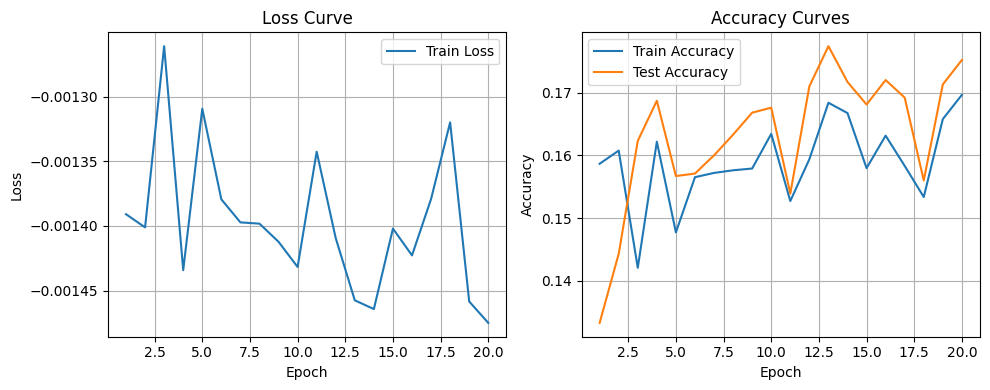

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,FWD,-0.001391,0.15866,0.1333,23.654141,24.163051,0.001,36.256385
1,2,FWD,-0.001401,0.16076,0.1443,28.259188,28.367850,0.001,36.130570
2,3,FWD,-0.001261,0.14208,0.1623,29.761763,29.774477,0.001,36.024770
3,4,FWD,-0.001434,0.16218,0.1687,33.807892,33.707734,0.001,36.131706
4,5,FWD,-0.001309,0.14772,0.1567,35.656398,35.743206,0.001,35.851156
5,6,FWD,-0.001379,0.15652,0.1571,36.783672,36.850042,0.001,36.234808
6,7,FWD,-0.001397,0.15720,0.1600,36.155928,36.011107,0.001,36.086734
7,8,FWD,-0.001398,0.15762,0.1633,43.355539,43.299108,0.001,36.392063
8,9,FWD,-0.001412,0.15790,0.1668,42.509181,42.347269,0.001,36.399841
9,10,FWD,-0.001432,0.16342,0.1676,44.750022,44.511844,0.001,36.311332


In [20]:
loss_code = "ps_2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.1437, Train Acc: 0.1079, Test Acc: 0.1099, Train Detached Loss: 57.3480, Test Detached Loss: 57.5261, Learning Rate: 0.001000, Epoch Time: 32.74 seconds
Epoch 20/20: Train Loss: -0.1678, Train Acc: 0.1684, Test Acc: 0.1630, Train Detached Loss: 100.5358, Test Detached Loss: 100.8712, Learning Rate: 0.001000, Epoch Time: 30.70 seconds
                        0
pseudo_label_model     MM
loss_name            ps_2
corr_p                0.2
optimizer            Adam
initial_lr          0.001
phi                   0.8


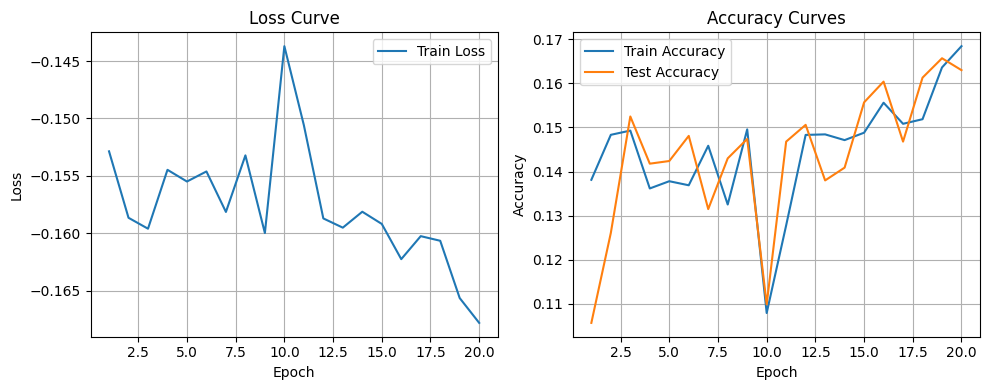

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MM,-0.152864,0.13814,0.1057,19.998925,19.883401,0.001,36.004554
1,2,MM,-0.158652,0.14834,0.1261,36.374111,36.432951,0.001,36.427905
2,3,MM,-0.159603,0.14930,0.1525,38.324771,38.257094,0.001,35.943891
3,4,MM,-0.154475,0.13618,0.1418,48.703902,48.834955,0.001,36.380658
4,5,MM,-0.155493,0.13782,0.1424,47.263402,47.607043,0.001,36.405525
5,6,MM,-0.154617,0.13690,0.1481,57.257206,57.571731,0.001,36.292674
6,7,MM,-0.158143,0.14586,0.1315,63.213149,62.652432,0.001,36.476912
7,8,MM,-0.153216,0.13254,0.1430,64.294055,64.038770,0.001,36.010885
8,9,MM,-0.159980,0.14958,0.1474,67.368817,67.222623,0.001,36.254581
9,10,MM,-0.143706,0.10794,0.1099,57.348048,57.526112,0.001,32.735095


In [21]:
loss_code = "ps_2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.7033, Train Acc: 0.6737, Test Acc: 0.6479, Train Detached Loss: 3.2752, Test Detached Loss: 2.8873, Learning Rate: 0.001000, Epoch Time: 30.79 seconds
Epoch 20/20: Train Loss: -0.8421, Train Acc: 0.7658, Test Acc: 0.6776, Train Detached Loss: 0.8724, Test Detached Loss: 1.1877, Learning Rate: 0.001000, Epoch Time: 30.60 seconds
                            0
pseudo_label_model        BWD
loss_name           spherical
corr_p                    0.2
optimizer                Adam
initial_lr              0.001
phi                       0.8


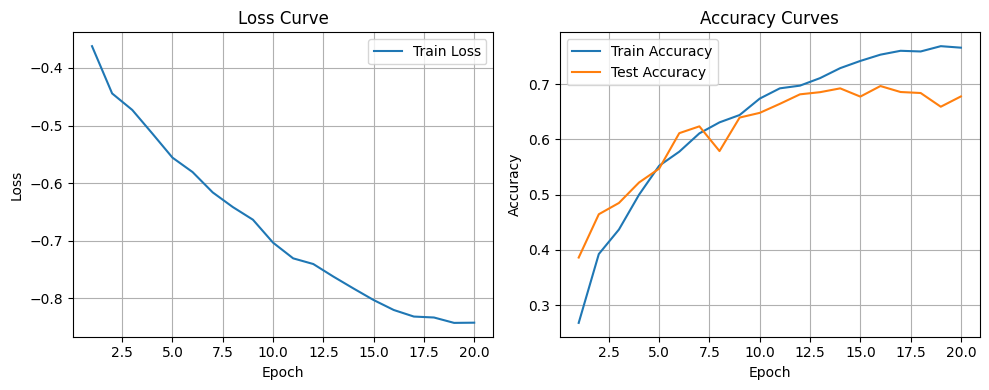

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,BWD,-0.362302,0.26816,0.3863,2.096554,2.030650,0.001,31.015372
1,2,BWD,-0.444355,0.39264,0.4646,3.126379,2.940466,0.001,30.885476
2,3,BWD,-0.472926,0.43694,0.4850,2.629736,2.651825,0.001,30.780265
3,4,BWD,-0.513942,0.49990,0.5220,2.861299,3.046795,0.001,30.602139
4,5,BWD,-0.555744,0.55226,0.5471,20.524783,21.743168,0.001,30.302039
5,6,BWD,-0.580774,0.57770,0.6112,1.630428,1.716520,0.001,30.843793
6,7,BWD,-0.616066,0.61084,0.6235,3.841270,4.130274,0.001,30.910643
7,8,BWD,-0.641474,0.63072,0.5788,5.796050,4.928316,0.001,30.521181
8,9,BWD,-0.663434,0.64400,0.6394,1.091631,1.135102,0.001,30.903044
9,10,BWD,-0.703267,0.67370,0.6479,3.275167,2.887256,0.001,30.793477


In [22]:
# #################
# Backward Proper Loss

loss_code = "spherical"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.9136, Train Acc: 0.8670, Test Acc: 0.7728, Train Detached Loss: 0.5682, Test Detached Loss: 0.8626, Learning Rate: 0.001000, Epoch Time: 30.74 seconds
Epoch 20/20: Train Loss: -0.9652, Train Acc: 0.9133, Test Acc: 0.7969, Train Detached Loss: 0.4906, Test Detached Loss: 0.9564, Learning Rate: 0.001000, Epoch Time: 30.58 seconds
                            0
pseudo_label_model         IR
loss_name           spherical
corr_p                    0.2
optimizer                Adam
initial_lr              0.001
phi                       0.8


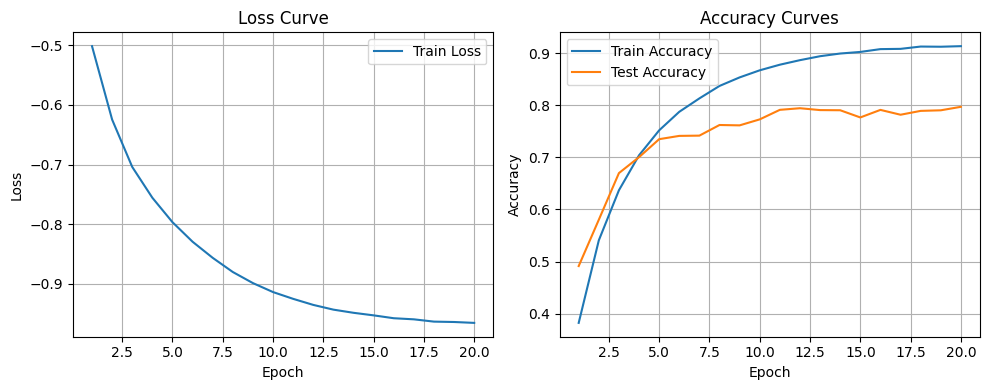

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,IR,-0.501762,0.38224,0.4913,2.805939,2.718481,0.001,30.624366
1,2,IR,-0.624726,0.54066,0.5802,1.235567,1.255528,0.001,30.660626
2,3,IR,-0.704068,0.63678,0.6697,0.927708,0.977338,0.001,30.492261
3,4,IR,-0.755650,0.70386,0.7003,0.839530,0.923997,0.001,30.525899
4,5,IR,-0.796585,0.75176,0.7348,0.727665,0.833794,0.001,30.703392
5,6,IR,-0.829342,0.78732,0.7411,0.674680,0.820027,0.001,30.209203
6,7,IR,-0.856288,0.81306,0.7416,0.683221,0.878315,0.001,30.881721
7,8,IR,-0.880040,0.83696,0.7620,0.592768,0.812213,0.001,30.488501
8,9,IR,-0.898617,0.85334,0.7613,0.612306,0.890817,0.001,30.356540
9,10,IR,-0.913642,0.86696,0.7728,0.568213,0.862577,0.001,30.744103


In [23]:
# #################
# Testing IR Loss

loss_code = "spherical"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: -0.8693, Train Acc: 0.2405, Test Acc: 0.2427, Train Detached Loss: 7.1672, Test Detached Loss: 7.2462, Learning Rate: 0.001000, Epoch Time: 29.70 seconds
Epoch 20/20: Train Loss: -0.9442, Train Acc: 0.3144, Test Acc: 0.2790, Train Detached Loss: 9.3431, Test Detached Loss: 9.6803, Learning Rate: 0.001000, Epoch Time: 29.59 seconds
                            0
pseudo_label_model       PiCO
loss_name           spherical
corr_p                    0.2
optimizer                Adam
initial_lr              0.001
phi                       0.8


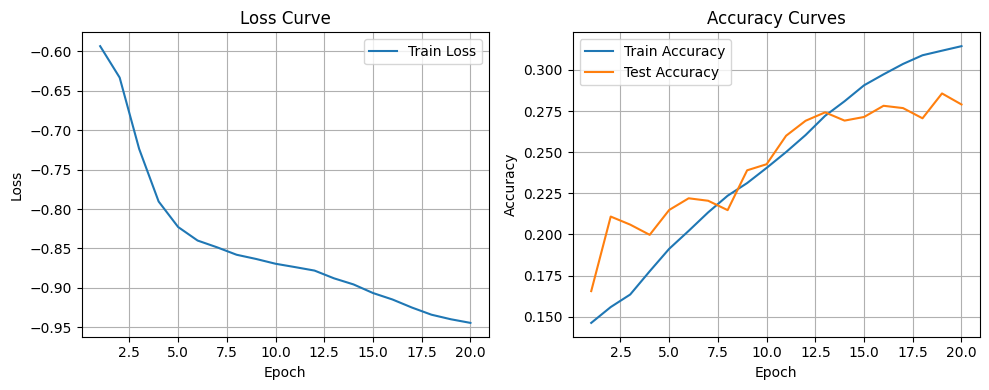

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,PiCO,-0.593676,0.14630,0.1656,4.549953,4.458187,0.001,29.591470
1,2,PiCO,-0.633463,0.15592,0.2109,7.954626,8.019824,0.001,29.600719
2,3,PiCO,-0.723791,0.16354,0.2060,9.376134,9.612011,0.001,29.588970
3,4,PiCO,-0.790448,0.17766,0.1998,12.202353,12.476098,0.001,29.655574
4,5,PiCO,-0.822762,0.19130,0.2149,7.388066,7.352883,0.001,29.636091
5,6,PiCO,-0.839930,0.20220,0.2220,7.577962,7.500658,0.001,29.600305
6,7,PiCO,-0.848511,0.21344,0.2205,7.410185,7.383391,0.001,29.651922
7,8,PiCO,-0.857917,0.22356,0.2148,8.022949,8.081151,0.001,29.695524
8,9,PiCO,-0.863255,0.23124,0.2390,6.964490,7.074670,0.001,29.762787
9,10,PiCO,-0.869334,0.24046,0.2427,7.167189,7.246231,0.001,29.701989


In [24]:
# #################
# Testing PiCO Loss

loss_code = "spherical"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Epoch 10/20: Train Loss: -0.9106, Train Acc: 0.8626, Test Acc: 0.7775, Train Detached Loss: 0.5508, Test Detached Loss: 0.8461, Learning Rate: 0.001000, Epoch Time: 30.63 seconds
Epoch 20/20: Train Loss: -0.9651, Train Acc: 0.9116, Test Acc: 0.7985, Train Detached Loss: 0.5188, Test Detached Loss: 1.0104, Learning Rate: 0.001000, Epoch Time: 30.52 seconds
                            0
pseudo_label_model         MC
loss_name           spherical
corr_p                    0.2
optimizer                Adam
initial_lr              0.001
phi                       0.8


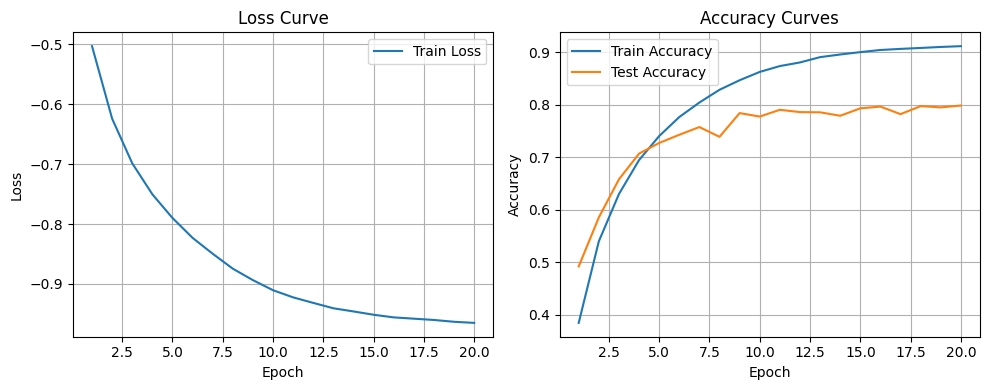

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,-0.502859,0.38436,0.4919,2.075916,2.044760,0.001,30.231029
1,2,MC,-0.623934,0.53970,0.5853,1.342539,1.356861,0.001,30.625444
2,3,MC,-0.698511,0.62978,0.6579,0.964692,0.996885,0.001,30.560956
3,4,MC,-0.750319,0.69454,0.7069,0.844834,0.908075,0.001,30.098460
4,5,MC,-0.789880,0.74032,0.7272,0.785085,0.898225,0.001,30.352743
5,6,MC,-0.823098,0.77656,0.7428,0.682464,0.820896,0.001,30.158778
6,7,MC,-0.849605,0.80424,0.7575,0.615447,0.779936,0.001,30.446875
7,8,MC,-0.874565,0.82852,0.7389,0.750226,0.982066,0.001,30.042811
8,9,MC,-0.893721,0.84672,0.7841,0.521687,0.779606,0.001,30.241723
9,10,MC,-0.910554,0.86256,0.7775,0.550759,0.846148,0.001,30.630687


In [25]:
# #################
# Marginal Chain

loss_code = "spherical"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: -0.1545, Train Acc: 0.7324, Test Acc: 0.6842, Train Detached Loss: 0.8801, Test Detached Loss: 1.0409, Learning Rate: 0.001000, Epoch Time: 30.06 seconds
Epoch 20/20: Train Loss: -0.1746, Train Acc: 0.8387, Test Acc: 0.7372, Train Detached Loss: 0.5326, Test Detached Loss: 0.8573, Learning Rate: 0.001000, Epoch Time: 30.28 seconds
                            0
pseudo_label_model        FWD
loss_name           spherical
corr_p                    0.2
optimizer                Adam
initial_lr              0.001
phi                       0.8


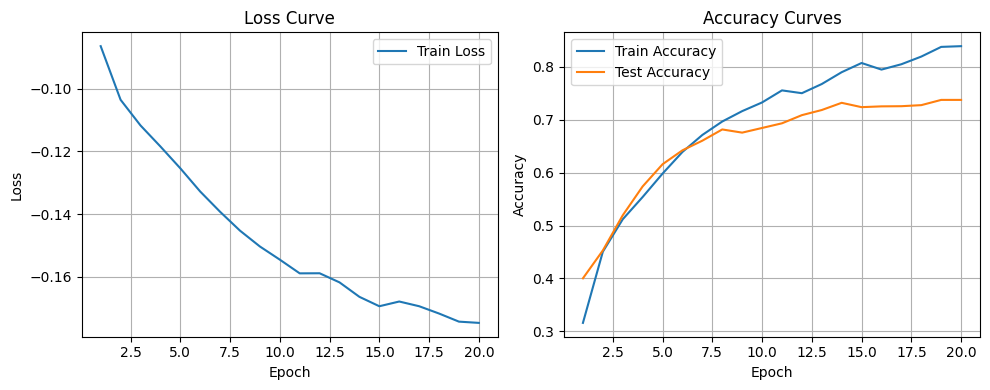

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,FWD,-0.086473,0.31614,0.4003,1.718016,1.694137,0.001,30.298022
1,2,FWD,-0.103556,0.45054,0.4529,5.247371,5.723719,0.001,30.482921
2,3,FWD,-0.111725,0.51180,0.5193,2.042395,2.111778,0.001,30.395598
3,4,FWD,-0.118427,0.55382,0.5738,1.363576,1.415144,0.001,30.363427
4,5,FWD,-0.125379,0.59800,0.6157,1.374442,1.492743,0.001,30.654051
5,6,FWD,-0.132782,0.63890,0.6420,1.059344,1.107560,0.001,30.628591
6,7,FWD,-0.139241,0.67100,0.6602,1.048464,1.092149,0.001,30.554832
7,8,FWD,-0.145254,0.69640,0.6814,0.911625,0.999207,0.001,30.685563
8,9,FWD,-0.150296,0.71598,0.6754,0.906234,1.034067,0.001,30.141552
9,10,FWD,-0.154485,0.73238,0.6842,0.880055,1.040908,0.001,30.059543


In [26]:
loss_code = "spherical"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [27]:
loss_code = "spherical"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

ValueError: Unknown loss_code=spherical

In [ ]:
# #################
# Backward Proper Loss

loss_code = "brier"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Epoch 10/20: Train Loss: 0.3465, Train Acc: 0.6471, Test Acc: 0.6191, Train Detached Loss: 4.5557, Test Detached Loss: 4.0457, Learning Rate: 0.001000, Epoch Time: 30.85 seconds


In [ ]:
# #################
# Testing IR Loss

loss_code = "brier"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "brier"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# ##############
# Marginal Chain

loss_code = "brier"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "brier"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

In [ ]:
loss_code = "brier"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Backward Proper Loss

loss_code = "tsallis_0.2"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Testing IR Loss

loss_code = "tsallis_0.2"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "tsallis_0.2"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# ##############
# Marginal Chain

loss_code = "tsallis_0.2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "tsallis_0.2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

In [ ]:
loss_code = "tsallis_0.2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
#%% All methods comparison (per base loss): save CSV + GridSpec figure
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import numpy as np
import pandas as pd
import random

def set_seed_all(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sanitize(s: str) -> str:
    return str(s).replace("/", "_").replace(" ", "_").replace(".", "p")

# --------- What to run ---------
base_losses = ["cross_entropy", "brier", "ps_2", "spherical", "tsallis_0.2"]

# Output directory
out_dir = Path("outputs/method_comparison")
out_dir.mkdir(parents=True, exist_ok=True)

# Plot options
show_train_acc = True          # dashed train_acc in the left panel
save_png = True
save_pdf = False

# Training options (use the SAME setting for all methods)
run_seed = 123                 # same init + same RNG for fair comparison
pico_phi = 0.8                 # PiCO hyperparameter
pseudo_label_loc = 3           # must match train_and_evaluate default / dataset.py

# Back up PiCO's mutable pseudo-label tensor (so PiCO won't leak into other runs)
pseudo_backup = None
try:
    pseudo_tensor = train_loader.dataset.tensors[pseudo_label_loc]
    pseudo_backup = pseudo_tensor.detach().clone()
except Exception as e:
    print("Warning: could not back up pseudo labels (PiCO reset may not work):", repr(e))

def restore_pseudo_labels():
    if pseudo_backup is None:
        return
    # in-place restore (important: do not reassign train_loader.dataset.tensors!)
    train_loader.dataset.tensors[pseudo_label_loc].copy_(pseudo_backup)

def make_loss(method: str, loss_code: str):
    """Factory for loss objects, keeping the same style as other notebook cells."""
    if method == "IR":
        return IRLoss(weakener.M, loss_code=loss_code)
    if method == "PiCO":
        return PiCOLoss(loss_code=loss_code)
    if method == "MC":
        return MarginalChainProperLoss(weakener.M, loss_code=loss_code)
    if method == "FWD":
        return ForwardProperLoss(weakener.M, loss_code=loss_code)
    if method == "BWD":
        # Default: use inverse matrix weakener.Y.T (requires compute_Y=True)
        B = weakener.Y.T
        F = np.eye(Data.num_classes)
        return ForwardBackwardProperLoss(B, F, loss_code=loss_code)
    if method == "MM":
        return UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
    raise ValueError(f"Unknown method: {method}")

methods = ["IR", "PiCO", "MC", "FWD", "BWD", "MM"]

for loss_code in base_losses:
    print(f"\n=== Base loss: {loss_code} ===")

    per_method = []

    for method in methods:
        print(f"  -> Running method: {method}")

        # Ensure PiCO doesn't change the dataset for other methods / other losses
        restore_pseudo_labels()

        # Same initialization for fair comparison
        set_seed_all(run_seed)

        # Fresh model + optimizer each run
        model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

        loss_fn = make_loss(method, loss_code)

        # Train
        model, df = train_and_evaluate(
            model, train_loader, test_loader, optimizer, loss_fn,
            num_epochs=num_epochs,
            pseudolabel_model=method,
            phi=pico_phi,
            seed=run_seed
        )

        df = df.copy()
        df["base_loss"] = loss_code
        per_method.append(df)

    # Restore again at the end of this base loss (clean state)
    restore_pseudo_labels()

    # --------- Save logs ---------
    all_df = pd.concat(per_method, ignore_index=True)
    tag = sanitize(loss_code)

    csv_path = out_dir / f"{tag}_logs.csv"
    all_df.to_csv(csv_path, index=False)
    print(f"Saved logs: {csv_path}")

    # --------- Plot: 2-column (GridSpec), left = accuracy, right = train loss ---------
    fig = plt.figure(figsize=(11, 4.8))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[2.2, 1.4], wspace=0.28, hspace=0.2)

    ax_acc = fig.add_subplot(gs[:, 0])   # left spans two rows
    ax_loss = fig.add_subplot(gs[:, 1])  # right spans two rows

    # Accuracy curves
    for method in methods:
        dfm = all_df[all_df["pseudolabel_model"] == method]
        ax_acc.plot(dfm["epoch"], dfm["test_acc"], label=f"{method} test")
        if show_train_acc and "train_acc" in dfm.columns:
            ax_acc.plot(dfm["epoch"], dfm["train_acc"], linestyle="--", label=f"{method} train")

    ax_acc.set_title(f"Accuracy comparison (base loss: {loss_code})")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.grid(True, alpha=0.3)
    ax_acc.legend(ncol=2, fontsize=9)

    # Train loss curves
    for method in methods:
        dfm = all_df[all_df["pseudolabel_model"] == method]
        ax_loss.plot(dfm["epoch"], dfm["train_loss"], label=method)

    ax_loss.set_title("Train loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Train loss")
    ax_loss.grid(True, alpha=0.3)
    ax_loss.legend(fontsize=9)

    fig.tight_layout()

    if save_png:
        fig_path = out_dir / f"{tag}_compare.png"
        fig.savefig(fig_path, dpi=200, bbox_inches="tight")
        print(f"Saved figure: {fig_path}")

    if save_pdf:
        fig_path = out_dir / f"{tag}_compare.pdf"
        fig.savefig(fig_path, bbox_inches="tight")
        print(f"Saved figure: {fig_path}")

    plt.show()


=== Base loss: cross_entropy ===
  -> Running method: IR
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/60: Train Loss: 0.3000, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.2969, Test Detached Loss: 0.2901, Learning Rate: 0.000001, Epoch Time: 3.40 seconds
Epoch 20/60: Train Loss: 0.2655, Train Acc: 0.9246, Test Acc: 0.9241, Train Detached Loss: 0.2761, Test Detached Loss: 0.2768, Learning Rate: 0.000001, Epoch Time: 3.00 seconds
Epoch 30/60: Train Loss: 0.2511, Train Acc: 0.9282, Test Acc: 0.9253, Train Detached Loss: 0.2678, Test Detached Loss: 0.2739, Learning Rate: 0.000001, Epoch Time: 3.06 seconds
Epoch 40/60: Train Loss: 0.2424, Train Acc: 0.9299, Test Acc: 0.9279, Train Detached Loss: 0.2631, Test Detached Loss: 0.2734, Learning Rate: 0.000001, Epoch Time: 3.09 seconds
Epoch 50/60: Train Loss: 0.2362, Train Acc: 0.9311, Test Acc: 0.9280, Train Detached Loss: 0.2600, Test Detached Loss: 0.2738, Learning Rate: 0.000001, Epoch Tim